# Домашнее задание к уроку 3  
Обучить СНС с помощью Transfer Learning на датасете Food-101    
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

In [1]:
# Загрузка библиотек

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Загрузка Food100

In [87]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split= ['train', 'validation'],
)

In [23]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [24]:
classes_list = ds_info.features['label'].names
classes_list

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [25]:
num_classes= 101

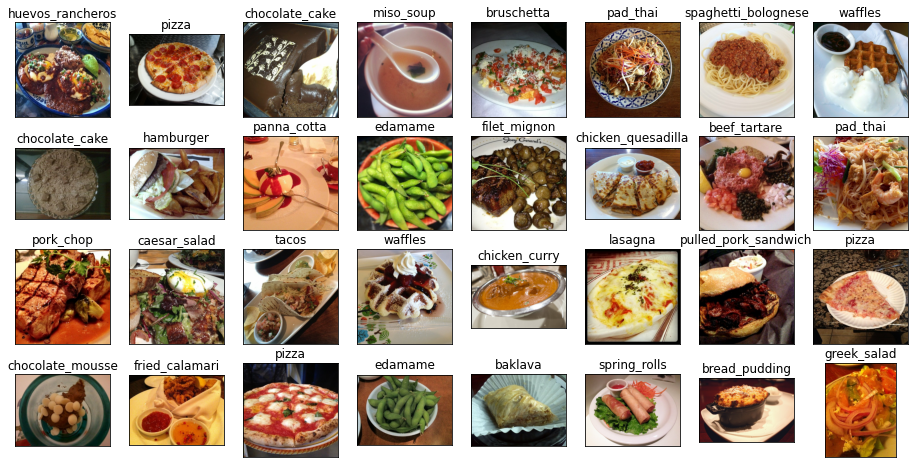

In [26]:
# визуализация

# сэмплируем объекты и метк класса
some_samples = [x for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j][0])
    plt.title(ds_info.features['label'].int2str((some_samples[j][1].numpy())))
    plt.xticks([]), plt.yticks([])
plt.show()

### Создание пайплайна данных

In [137]:
INP_SIZE = 160
NUM_EPOCHS = 10
BATCH_SIZE = 64

In [138]:
def prepare(img):
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return tf.keras.applications.resnet50.preprocess_input(img)

In [139]:
train = train_ds.map(lambda x, y: (prepare(x), y))
test = test_ds.map(lambda x, y: (prepare(x), y))

train = train.batch(BATCH_SIZE, drop_remainder=True)
test = test.batch(BATCH_SIZE, drop_remainder=True)

In [140]:
# Добавим аугментацию

augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.Resizing(200, 200),
  # tf.keras.layers.RandomCrop(160,160),
])

In [141]:
ds_train = train.map(lambda x, y: (augmentation(x, training=True), y))

### Подготовка модели к обучению

In [142]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(INP_SIZE, INP_SIZE, 3),
)

resnet_model.trainable = True

**При "заморозке" весов ResNet модели метрика при обучении не двигалась, сеть обучалась минимально, выдавая низкие результаты метрик, поэтому решила обучить ResNet заново на своих данных.**

In [143]:
model = tf.keras.Sequential([
    resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes),
])

In [144]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 101)               206949    
                                                                 
Total params: 23,794,661
Trainable params: 23,741,541
Non-trainable params: 53,120
_________________________________________________________________


In [145]:
LEARNING_RATE = 1e-5
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir='logs/transf_learning', 
#     write_graph=False, update_freq=100, profile_batch=0)

In [147]:
%%time

history = model.fit(
    ds_train,
    epochs=NUM_EPOCHS,
    validation_data=ds_test,
    # callbacks=[tensorboard_callback]
    )

Epoch 1/10
1183/1183 [==============================] - 854s 722ms/step - loss: 2.3429 - accuracy: 0.4376 - val_loss: 2.0262 - val_accuracy: 0.4879
Epoch 2/10
1183/1183 [==============================] - 863s 729ms/step - loss: 1.8833 - accuracy: 0.5305 - val_loss: 1.7650 - val_accuracy: 0.5480
Epoch 3/10
1183/1183 [==============================] - 856s 723ms/step - loss: 1.6405 - accuracy: 0.5833 - val_loss: 1.6230 - val_accuracy: 0.5770
Epoch 4/10
1183/1183 [==============================] - 854s 722ms/step - loss: 1.4744 - accuracy: 0.6197 - val_loss: 1.5274 - val_accuracy: 0.5975
Epoch 5/10
1183/1183 [==============================] - 857s 724ms/step - loss: 1.3464 - accuracy: 0.6488 - val_loss: 1.4606 - val_accuracy: 0.6145
Epoch 6/10
1183/1183 [==============================] - 853s 721ms/step - loss: 1.2432 - accuracy: 0.6735 - val_loss: 1.4072 - val_accuracy: 0.6263
Epoch 7/10
1183/1183 [==============================] - 854s 722ms/step - loss: 1.1557 - accuracy: 0.6947 - val_

In [150]:
model.evaluate(test)

394/394 [==============================] - 69s 169ms/step - loss: 1.2130 - accuracy: 0.6769


[1.2129948139190674, 0.6768718361854553]

Text(0, 0.5, 'Accuracy')

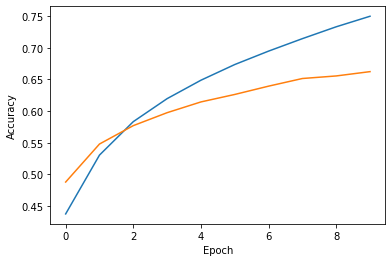

In [151]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Метрика на тренировочных данных растет быстрее, чем на тестовых, что говорит о переобучении.  

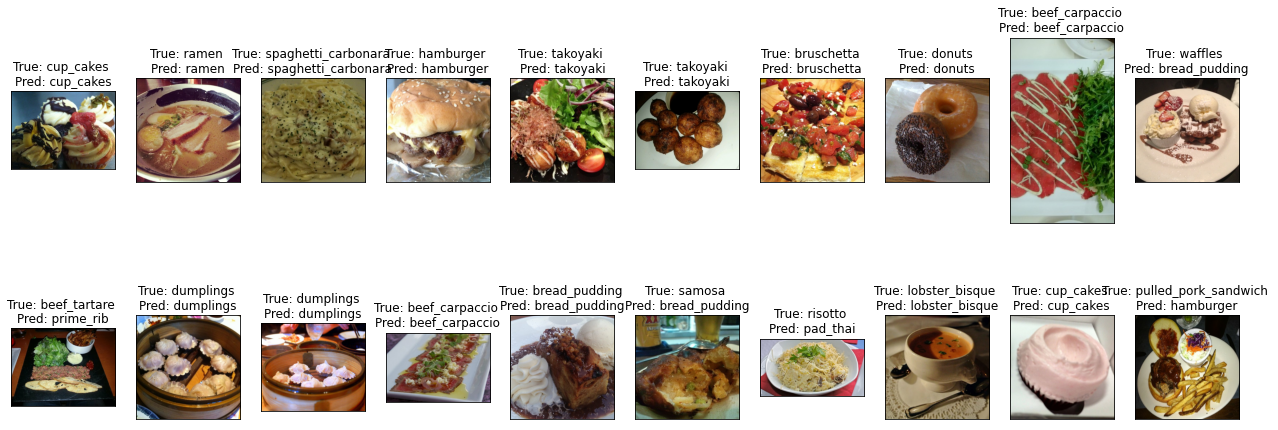

In [152]:
some_samples = [x for x in iter(test_ds.take(20))]

fig = plt.figure(figsize=(22, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(2, 10, j+1)
    ax.imshow(some_samples[j][0])

    img = prepare(some_samples[j][0])
    pred = np.argmax(model(img[None,...]))
    plt.title(f"True: {ds_info.features['label'].int2str((some_samples[j][1]))} \nPred: {ds_info.features['label'].int2str(pred)}")
    plt.xticks([]), plt.yticks([])
plt.show()

- Предсказания модели не всегда верны. 
- Аугментация положительно повлияла на результат.